<a href="https://colab.research.google.com/github/rhehgus02/ESAA_OB/blob/main/%EC%BA%90%EA%B8%80_%EC%8B%A4%EC%8A%B5_%ED%95%84%EC%82%AC(7)_%EC%BC%80%EB%9D%BC%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **기본 분류: 의류 이미지 분류**

링크: https://www.tensorflow.org/tutorials/keras/classification?hl=ko

이 튜토리얼에서는 운동화나 셔츠 같은 옷 이미지를 분류하는 신경망 모델을 훈련함

여기에서는 텐서플로 모델을 만들고 훈련할 수 있는 고수준 API인 tf.keras를 사용함

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.14.0


---

## **1. 패션 MNIST 데이터셋 임포트하기**

* 패션 MNIST는 컴퓨터 비전 분야의 "Hello, World" 프로그램격인 고전 MNIST 데이터셋을 대신해서 자주 사용됨

    * 두 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 보통 사용되며, 코드를 테스트하고 디버깅하는 용도로 좋음

* 10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용

    * 이미지는 해상도(28x28 픽셀)가 낮고 개별 옷 품목을 나타냄

    * 60,000개의 이미지를 사용하여 네트워크를 훈련하고 10,000개의 이미지를 사용하여 네트워크에서 이미지 분류를 학습한 정도를 평가함

    * TensorFlow에서 직접 Fashion MNIST 데이터를 가져오고 로드 가능

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


>> train_images와 train_labels 배열은 모델 학습에 사용되는 훈련 세트

>> test_images와 test_labels 배열은 모델 테스트에 사용되는 테스트 세트

* 이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이임

    * 레이블(label)은 0에서 9까지의 정수 배열임
    
        -> 이 값은 이미지에 있는 옷의 클래스(class)를 나타냄

        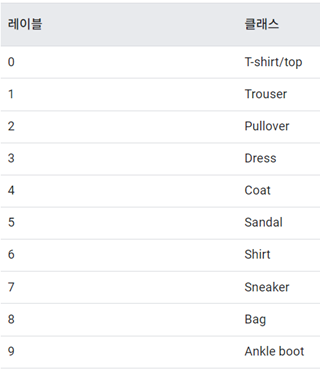

In [3]:
# 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

---

## **2. 데이터 탐색**

In [4]:
train_images.shape

(60000, 28, 28)

>> 훈련 세트에 60,000개의 이미지가 있고, 각 이미지는 28x28 픽셀로 표현됨

In [5]:
len(train_labels)

60000

>> 훈련 세트에는 60,000개의 레이블이 있음

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

>> 각 레이블은 0과 9사이의 정수

In [7]:
test_images.shape

(10000, 28, 28)

>> 테스트 세트에는 10,000개의 이미지가 있고, 이 이미지도 28x28 픽셀로 표현됨

In [8]:
len(test_labels)

10000

>> 테스트 세트는 10,000개의 이미지에 대한 레이블을 가지고 있음

---

## **3. 데이터 전처리**

* 네트워크를 훈련하기 전에 데이터를 전처리해야 함

* 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있음

    -> 신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정
    
    -> 이렇게 하려면 255로 나누어야 하며 훈련 세트와 테스트 세트를 동일한 방식으로 전처리하는 것이 중요

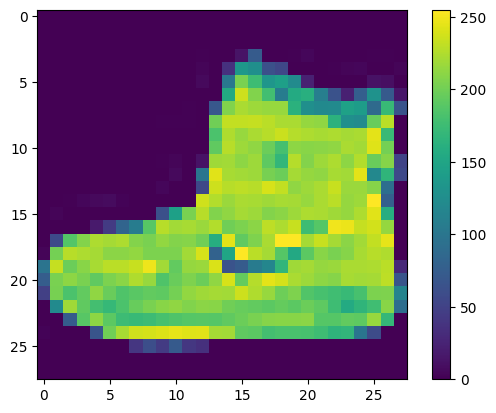

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

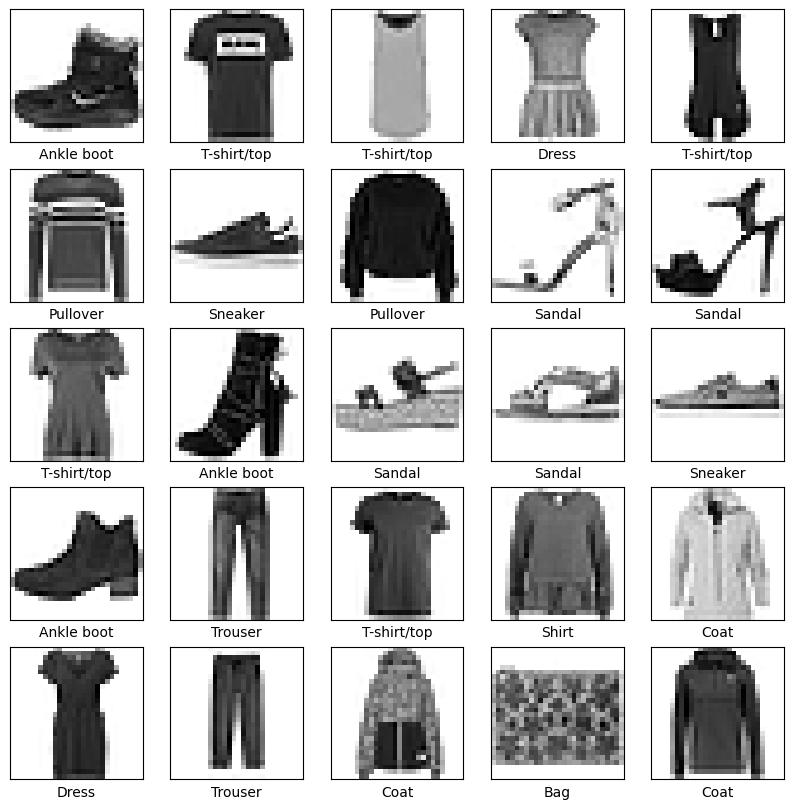

In [11]:
# 훈련 세트에서 처음 25개 이미지와 그 아래 클래스 이름을 출력

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

---

## **4. 모델 구성**

### **4-1. 층 설정**

* 신경망의 기본 빌딩 블록은 레이어(layer)임

    * 대부분 딥러닝은 간단한 층을 연결하여 구성됨

    * tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됨

* 첫 번째 층인 tf.keras.layers.Flatten은 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환함

    -> 이 층에는 학습되는 가중치가 없고 데이터를 변환하기만 함

* 픽셀을 펼친 후에는 두 개의 tf.keras.layers.Dense 층이 연속되어 연결됨

    -> 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부름

    * 첫 번째 Dense 층은 128개의 노드를 가짐
    
    * 두 번째 (마지막) 층은 10개의 노드의 소프트맥스(softmax) 층
    
        -> 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1
        
        -> 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

---

### **4-2. 모델 컴파일**

* 모델을 훈련시키기 전에 몇 가지 설정이 더 필요하며 모델의 컴파일 단계에서 추가됨

    * 손실 함수: 훈련 중 모델이 얼마나 정확한지 측정함
    
        -> 모델을 올바른 방향으로 "조정"하려면 이 함수를 최소화해야 함

    * 옵티마이저: 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식

    * 메트릭: 훈련 및 테스트 단계를 모니터링하는 데 사용됨
    

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

---

## **5. 모델 훈련**

* 신경망 모델을 훈련하려면 다음 단계가 필요함

    * 훈련 데이터를 모델에 주입
    
        -> 이 예에서는 train_images와 train_labels 배열

    * 모델이 이미지와 레이블을 매핑하는 방법을 학습

    * 테스트 세트에 대한 모델의 예측을 만듦
    
        -> 이 예에서는 test_images 배열

    * 예측이 test_labels 배열의 레이블과 일치하는지 확인



---

### **5-1. 모델 피드**

* 훈련을 시작하려면 `model.fit` 메서드를 호출

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.5037 - accuracy: 0.8231
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3794 - accuracy: 0.8637
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3418 - accuracy: 0.8753
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3149 - accuracy: 0.8852
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2972 - accuracy: 0.8900
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2813 - accuracy: 0.8967
Epoch 7/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2673 - accuracy: 0.9006
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2582 - accuracy: 0.9034
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2468 - accuracy: 0.9082
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss:

>> 모델이 훈련되면서 손실과 정확도 지표가 출력됨

>> 이 모델은 훈련 세트에서 약 91% 정도의 정확도를 달성함

---

### **5-2. 정확도 평가**

* 모델이 테스트 데이터세트에서 작동하는 방식을 비교

In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3658 - accuracy: 0.8724 - 627ms/epoch - 2ms/step

Test accuracy: 0.8723999857902527


>> 테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮음

>> 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문

>> 과대적합: 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상

---

### **5-3. 예측하기**

* 훈련된 모델을 사용하여 일부 이미지에 대한 예측 수행 가능

* 소프트맥스 레이어를 연결하여 로짓을 해석하기 쉬운 확률로 변환

In [16]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [17]:
# 테스트 세트에 있는 각 이미지의 레이블을 예측
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [18]:
# 첫 번째 예측을 확인
predictions[0]

array([1.4572683e-07, 6.4996719e-12, 7.4409003e-09, 3.1468916e-09,
       3.3557577e-09, 1.8217020e-02, 1.8819824e-07, 2.1396628e-02,
       1.8004096e-07, 9.6038574e-01], dtype=float32)

>> 이 예측은 10개의 숫자 배열로 나타남

>> 각각의 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냄

In [19]:
np.argmax(predictions[0])

9

>> 모델은 이 이미지가 앵클 부츠(class_name[9])라고 예측함

In [20]:
test_labels[0]

9

>> 예측과 맞음

In [21]:
# 10개 클래스에 대한 예측을 모두 그래프로 표현

def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

---

### **5-4. 예측 확인**

* 훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행 가능

* 0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인

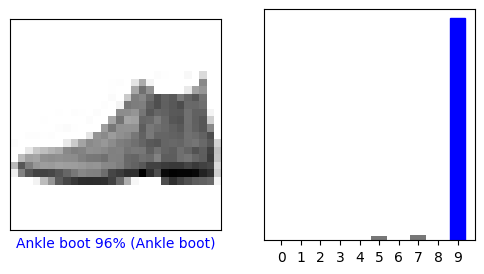

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

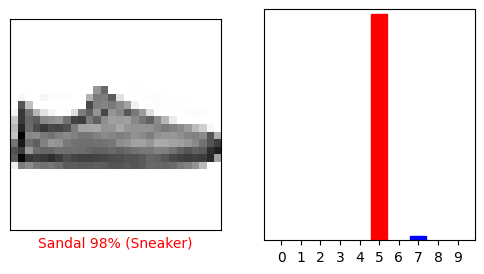

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

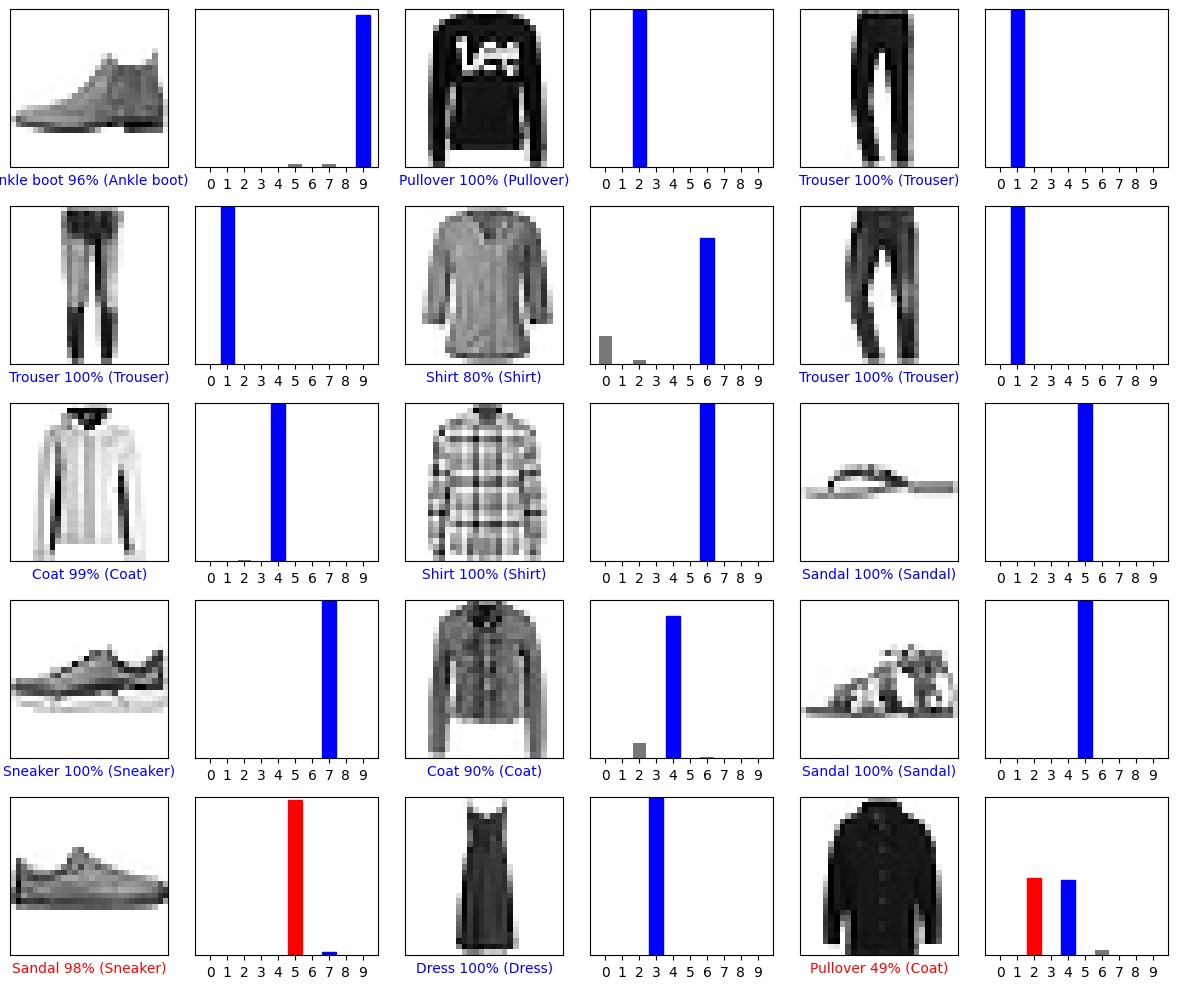

In [24]:
# 몇 개의 이미지의 예측을 출력
# 올바르게 예측된 레이블은 파란색이고 잘못 예측된 레이블은 빨강색
# 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

---

## **6. 훈련된 모델 사용하기**

* 마지막으로 훈련된 모델을 사용하여 한 이미지에 대한 예측을 만듦

* tf.keras 모델은 한 번에 샘플의 묶음 또는 배치(batch)로 예측을 만드는데 최적화되어 있음

    -> 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 함

* tf.keras.Model.predict는 데이터 배치의 각 이미지에 대해 하나의 목록씩 목록의 목록을 반환함

    -> 배치에서 (유일한) 이미지에 대한 예측을 가져옴

In [25]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


In [26]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [27]:
# 이미지 예측
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 36ms/step
[[5.3085841e-04 2.8961452e-13 9.9546742e-01 7.1169297e-09 3.9355690e-03
  7.3185125e-10 6.6135515e-05 1.9950582e-17 2.5349491e-09 2.2410849e-14]]


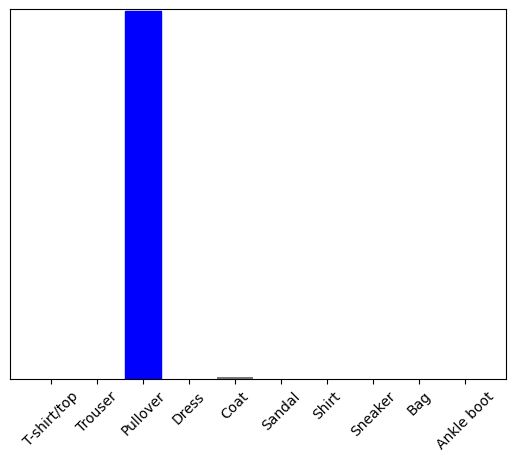

In [28]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

In [29]:
np.argmax(predictions_single[0])

2